In [28]:
import librosa
import numpy as np
import pandas as pd
import os

In [16]:
audio_file_path='UrbanSound8K/audio/fold3/98681-9-0-6.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [17]:
print(librosa_audio_data)

[-0.00976551 -0.0099922  -0.01322963 ... -0.01712941 -0.00509277
  0.00135862]


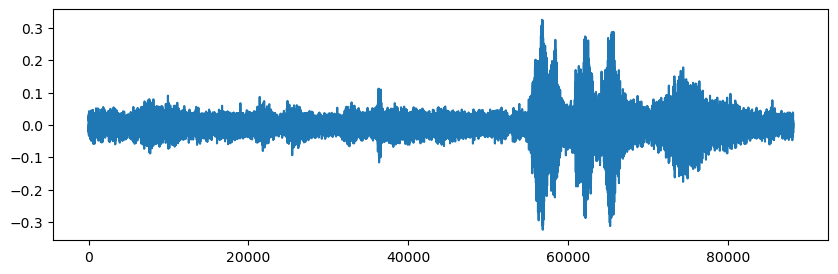

In [22]:
### Lets plot the librosa audio data
import matplotlib.pyplot as plt
# Original audio with 1 channel 
plt.figure(figsize=(10, 3))
plt.plot(librosa_audio_data)

In [19]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path) 

In [20]:
wave_audio

array([[-297, -554],
       [-231, -503],
       [-258, -397],
       ...,
       [ -19,   33],
       [ 148,  170],
       [ -79, -124]], dtype=int16)

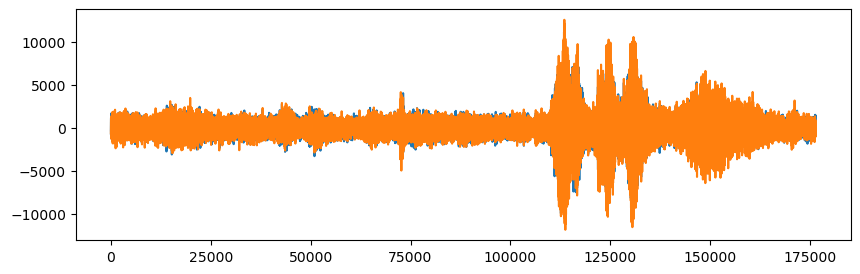

In [23]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(10, 3))
plt.plot(wave_audio)

In [24]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [25]:
mfccs

array([[-2.51391174e+02, -2.16801056e+02, -2.20687836e+02, ...,
        -2.38029175e+02, -2.36554962e+02, -2.53379135e+02],
       [ 6.57023315e+01,  7.07318573e+01,  7.05150375e+01, ...,
         7.97825470e+01,  7.48421326e+01,  7.28841171e+01],
       [-5.04065437e+01, -4.87269058e+01, -4.54891129e+01, ...,
        -3.63244781e+01, -3.86985779e+01, -3.99087677e+01],
       ...,
       [ 5.89234591e-01,  9.72601891e-01,  2.80757093e+00, ...,
        -2.42832351e+00, -4.21725869e-01, -2.10761023e+00],
       [ 5.22178078e+00,  2.48890495e+00,  1.59127545e+00, ...,
         1.02481365e-01,  2.37794018e+00, -3.10849953e+00],
       [ 1.67661035e+00,  1.76294565e+00,  7.06721187e-01, ...,
        -1.29168355e+00,  1.27929401e+00,  2.90761185e+00]], dtype=float32)

In [26]:
#### Extracting MFCC's For every audio file

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [37]:
import librosa
import numpy as np
import resampy

def features_extractor(file):
    audio, sample_rate = librosa.load(file, sr=None)
    target_sample_rate = 22050  # Specify your desired sample rate
    audio_resampled = resampy.resample(audio, sample_rate, target_sample_rate)
    mfccs_features = librosa.feature.mfcc(y=audio_resampled, sr=target_sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features


In [39]:
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

8325it [37:35,  6.18it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1102
  warnings.warn(
8328it [37:35, 10.15it/s]C:\Users\DELL\anaconda3\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1522
  warnings.warn(
8732it [39:06,  3.72it/s]


In [40]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-214.35951, 66.00463, -126.225266, -57.349586...",dog_bark
1,"[-420.23825, 103.904526, -47.55043, 55.606483,...",children_playing
2,"[-455.2568, 116.408104, -41.610703, 47.2071, 4...",children_playing
3,"[-409.9394, 96.085556, -29.91929, 47.63835, 6....",children_playing
4,"[-442.84656, 108.39454, -47.17804, 55.187874, ...",children_playing


In [41]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [42]:
X.shape

(8732, 40)

In [43]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [44]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [45]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [46]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [47]:
X_train

array([[-1.27237671e+02,  1.07059235e+02, -1.71941109e+01, ...,
         5.27670670e+00, -3.36865258e+00,  4.71800900e+00],
       [-9.25005817e+00,  8.48568268e+01, -1.63288379e+00, ...,
        -1.51710081e+00, -6.99910307e+00,  1.43418998e-01],
       [-4.47588158e+01, -6.94172144e+00, -1.33627224e+01, ...,
         3.81022644e+00, -2.55708575e+00,  4.45782137e+00],
       ...,
       [-4.26941742e+02,  9.19913635e+01,  3.75123096e+00, ...,
         9.33147192e-01,  5.69307089e-01,  8.49631310e-01],
       [-1.41401093e+02,  1.30131836e+02, -2.74498005e+01, ...,
         3.24215436e+00, -3.76869512e+00,  8.55954230e-01],
       [-4.19415497e+02,  2.08316177e+02,  5.78602314e+00, ...,
        -4.56691599e+00, -4.09807587e+00, -9.33843613e-01]], dtype=float32)

In [48]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [49]:
X_train.shape

(6985, 40)

In [50]:
X_test.shape

(1747, 40)

In [51]:
y_train.shape

(6985, 10)

In [52]:
y_test.shape

(1747, 10)

# Model Creation


In [53]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adadelta
from sklearn import metrics

In [69]:
### No of classes
num_labels=y.shape[1]

In [70]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [104]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [105]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
205/219 [===========================>..] - ETA: 0s - loss: 1.1882 - accuracy: 0.6000
Epoch 1: val_loss improved from inf to 0.95481, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 2s 6ms/step - loss: 1.1855 - accuracy: 0.6016 - val_loss: 0.9548 - val_accuracy: 0.6812
Epoch 2/100
217/219 [============================>.] - ETA: 0s - loss: 1.1717 - accuracy: 0.6086
Epoch 2: val_loss improved from 0.95481 to 0.93256, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 1.1732 - accuracy: 0.6079 - val_loss: 0.9326 - val_accuracy: 0.6846
Epoch 3/100
205/219 [===========================>..] - ETA: 0s - loss: 1.1682 - accuracy: 0.6131
Epoch 3: val_loss improved from 0.93256 to 0.91979, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 1.1682 - accuracy: 0.6129 - val_loss: 0.9198 - val_accuracy: 0.6875

219/219 [==============================] - 1s 4ms/step - loss: 1.1002 - accuracy: 0.6349 - val_loss: 0.8936 - val_accuracy: 0.7144
Epoch 29/100
211/219 [===========================>..] - ETA: 0s - loss: 1.0955 - accuracy: 0.6306
Epoch 29: val_loss did not improve from 0.87952
219/219 [==============================] - 1s 5ms/step - loss: 1.0952 - accuracy: 0.6302 - val_loss: 0.9158 - val_accuracy: 0.6978
Epoch 30/100
203/219 [==========================>...] - ETA: 0s - loss: 1.1161 - accuracy: 0.6302
Epoch 30: val_loss did not improve from 0.87952
219/219 [==============================] - 1s 4ms/step - loss: 1.1165 - accuracy: 0.6283 - val_loss: 0.8857 - val_accuracy: 0.7035
Epoch 31/100
218/219 [============================>.] - ETA: 0s - loss: 1.1000 - accuracy: 0.6254
Epoch 31: val_loss did not improve from 0.87952
219/219 [==============================] - 1s 4ms/step - loss: 1.1003 - accuracy: 0.6255 - val_loss: 0.8888 - val_accuracy: 0.7189
Epoch 32/100
209/219 [================

219/219 [==============================] - 1s 3ms/step - loss: 1.0417 - accuracy: 0.6488 - val_loss: 0.8460 - val_accuracy: 0.7270
Epoch 58/100
210/219 [===========================>..] - ETA: 0s - loss: 1.0640 - accuracy: 0.6432
Epoch 58: val_loss improved from 0.83868 to 0.83470, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 1.0588 - accuracy: 0.6455 - val_loss: 0.8347 - val_accuracy: 0.7212
Epoch 59/100
215/219 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.6464
Epoch 59: val_loss improved from 0.83470 to 0.81716, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 1.0393 - accuracy: 0.6461 - val_loss: 0.8172 - val_accuracy: 0.7390
Epoch 60/100
212/219 [============================>.] - ETA: 0s - loss: 1.0686 - accuracy: 0.6372
Epoch 60: val_loss did not improve from 0.81716
219/219 [==============================] - 1s 5ms

204/219 [==========================>...] - ETA: 0s - loss: 1.0333 - accuracy: 0.6497
Epoch 86: val_loss did not improve from 0.79596
219/219 [==============================] - 1s 4ms/step - loss: 1.0268 - accuracy: 0.6513 - val_loss: 0.8181 - val_accuracy: 0.7344
Epoch 87/100
208/219 [===========================>..] - ETA: 0s - loss: 1.0396 - accuracy: 0.6541
Epoch 87: val_loss did not improve from 0.79596
219/219 [==============================] - 1s 4ms/step - loss: 1.0344 - accuracy: 0.6564 - val_loss: 0.8209 - val_accuracy: 0.7355
Epoch 88/100
207/219 [===========================>..] - ETA: 0s - loss: 1.0247 - accuracy: 0.6492
Epoch 88: val_loss did not improve from 0.79596
219/219 [==============================] - 1s 4ms/step - loss: 1.0298 - accuracy: 0.6477 - val_loss: 0.8372 - val_accuracy: 0.7281
Epoch 89/100
212/219 [============================>.] - ETA: 0s - loss: 1.0306 - accuracy: 0.6529
Epoch 89: val_loss did not improve from 0.79596
219/219 [===========================

In [67]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7630223035812378


In [63]:
X_test[1]

array([-4.6487424e+02, -8.1261736e-01, -3.2128014e+01,  3.3497120e+01,
       -1.3092374e+01, -2.0842447e+01,  1.0464629e+00, -1.7664865e+01,
       -1.9919134e+01,  6.3708487e+00, -2.7985310e+01, -1.9995079e+01,
       -2.0455415e+00, -8.9329824e+00, -1.4518441e+01, -7.1040964e+00,
       -7.2061262e+00,  9.1060438e+00,  1.4543973e+01,  2.1941620e+01,
        2.0745825e+01,  1.5504035e+00, -1.9538540e+01, -4.2390985e+00,
       -1.5212809e+00,  3.7430677e+00, -7.5642486e+00, -1.5785934e+01,
       -1.0690853e+01,  1.3697975e+01, -1.7725195e-01, -2.3123154e+01,
       -1.5995796e+01,  9.9720440e+00,  9.6464834e+00,  1.2977092e-01,
       -1.9604937e+00,  1.8381895e+01,  1.3183884e+01, -4.5467687e+00],
      dtype=float32)

In [65]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)


55/55 [==============================] - 0s 2ms/step


In [66]:
predictions

array([[3.33329022e-04, 1.84018063e-04, 1.44518039e-03, ...,
        6.08928508e-09, 1.04757382e-04, 5.64591447e-03],
       [3.51912854e-06, 9.97489318e-03, 6.46500662e-03, ...,
        2.25237113e-06, 6.34486147e-04, 5.26832603e-03],
       [4.08193795e-03, 2.00607274e-02, 6.16998458e-03, ...,
        5.60020208e-01, 1.21428305e-03, 4.50636670e-02],
       ...,
       [5.77486361e-08, 9.95810390e-01, 7.22638797e-05, ...,
        2.08007006e-13, 9.38208359e-07, 3.36882472e-03],
       [1.22943841e-01, 1.37526738e-02, 2.86730528e-01, ...,
        3.14300284e-02, 1.07405735e-02, 3.38942915e-01],
       [1.69429392e-01, 1.11217890e-02, 2.26095989e-01, ...,
        3.75692820e-04, 1.59141365e-02, 1.18868425e-01]], dtype=float32)

In [72]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='RMSprop')

In [73]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 120
num_batch_size = 42

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/120
163/167 [============================>.] - ETA: 0s - loss: 9.9683 - accuracy: 0.1164 
Epoch 1: val_loss improved from inf to 2.28954, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 5ms/step - loss: 9.8173 - accuracy: 0.1152 - val_loss: 2.2895 - val_accuracy: 0.1185
Epoch 2/120
164/167 [============================>.] - ETA: 0s - loss: 2.3580 - accuracy: 0.1516
Epoch 2: val_loss improved from 2.28954 to 2.11809, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 3ms/step - loss: 2.3553 - accuracy: 0.1522 - val_loss: 2.1181 - val_accuracy: 0.2467
Epoch 3/120
160/167 [===========================>..] - ETA: 0s - loss: 2.1709 - accuracy: 0.1994
Epoch 3: val_loss improved from 2.11809 to 1.95567, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 4ms/step - loss: 2.1681 - accuracy: 0.2006 - val_loss: 1.9557 - val_accuracy: 0.294

164/167 [============================>.] - ETA: 0s - loss: 1.3591 - accuracy: 0.5486
Epoch 26: val_loss did not improve from 1.13666
167/167 [==============================] - 0s 3ms/step - loss: 1.3641 - accuracy: 0.5479 - val_loss: 1.1458 - val_accuracy: 0.6234
Epoch 27/120
157/167 [===========================>..] - ETA: 0s - loss: 1.3763 - accuracy: 0.5510
Epoch 27: val_loss did not improve from 1.13666
167/167 [==============================] - 1s 3ms/step - loss: 1.3711 - accuracy: 0.5528 - val_loss: 1.1467 - val_accuracy: 0.6411
Epoch 28/120
166/167 [============================>.] - ETA: 0s - loss: 1.3495 - accuracy: 0.5607
Epoch 28: val_loss improved from 1.13666 to 1.10133, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 3ms/step - loss: 1.3487 - accuracy: 0.5609 - val_loss: 1.1013 - val_accuracy: 0.6474
Epoch 29/120
167/167 [==============================] - ETA: 0s - loss: 1.3333 - accuracy: 0.5676
Epoch 29: val_loss impro

167/167 [==============================] - 1s 3ms/step - loss: 1.2402 - accuracy: 0.6094 - val_loss: 1.0405 - val_accuracy: 0.6646
Epoch 54/120
163/167 [============================>.] - ETA: 0s - loss: 1.2447 - accuracy: 0.5958
Epoch 54: val_loss did not improve from 1.00031
167/167 [==============================] - 1s 3ms/step - loss: 1.2470 - accuracy: 0.5950 - val_loss: 1.0128 - val_accuracy: 0.6691
Epoch 55/120
160/167 [===========================>..] - ETA: 0s - loss: 1.2118 - accuracy: 0.6010
Epoch 55: val_loss did not improve from 1.00031
167/167 [==============================] - 1s 3ms/step - loss: 1.2123 - accuracy: 0.6006 - val_loss: 1.0405 - val_accuracy: 0.6674
Epoch 56/120
162/167 [============================>.] - ETA: 0s - loss: 1.2031 - accuracy: 0.6104
Epoch 56: val_loss did not improve from 1.00031
167/167 [==============================] - 1s 3ms/step - loss: 1.2015 - accuracy: 0.6099 - val_loss: 1.0126 - val_accuracy: 0.6743
Epoch 57/120
159/167 [================

154/167 [==========================>...] - ETA: 0s - loss: 1.1754 - accuracy: 0.6243
Epoch 82: val_loss did not improve from 0.95230
167/167 [==============================] - 1s 4ms/step - loss: 1.1729 - accuracy: 0.6249 - val_loss: 0.9886 - val_accuracy: 0.6691
Epoch 83/120
158/167 [===========================>..] - ETA: 0s - loss: 1.1722 - accuracy: 0.6313
Epoch 83: val_loss did not improve from 0.95230
167/167 [==============================] - 1s 4ms/step - loss: 1.1825 - accuracy: 0.6295 - val_loss: 1.0214 - val_accuracy: 0.6926
Epoch 84/120
165/167 [============================>.] - ETA: 0s - loss: 1.1890 - accuracy: 0.6280
Epoch 84: val_loss did not improve from 0.95230
167/167 [==============================] - 1s 4ms/step - loss: 1.1899 - accuracy: 0.6279 - val_loss: 1.0070 - val_accuracy: 0.6920
Epoch 85/120
155/167 [==========================>...] - ETA: 0s - loss: 1.1684 - accuracy: 0.6373
Epoch 85: val_loss did not improve from 0.95230
167/167 [===========================

163/167 [============================>.] - ETA: 0s - loss: 1.1522 - accuracy: 0.6363
Epoch 111: val_loss did not improve from 0.93388
167/167 [==============================] - 1s 4ms/step - loss: 1.1470 - accuracy: 0.6379 - val_loss: 0.9543 - val_accuracy: 0.7069
Epoch 112/120
152/167 [==========================>...] - ETA: 0s - loss: 1.1587 - accuracy: 0.6465
Epoch 112: val_loss did not improve from 0.93388
167/167 [==============================] - 1s 4ms/step - loss: 1.1655 - accuracy: 0.6458 - val_loss: 0.9464 - val_accuracy: 0.7115
Epoch 113/120
166/167 [============================>.] - ETA: 0s - loss: 1.1675 - accuracy: 0.6440
Epoch 113: val_loss did not improve from 0.93388
167/167 [==============================] - 1s 4ms/step - loss: 1.1669 - accuracy: 0.6438 - val_loss: 0.9989 - val_accuracy: 0.7041
Epoch 114/120
164/167 [============================>.] - ETA: 0s - loss: 1.1445 - accuracy: 0.6423
Epoch 114: val_loss did not improve from 0.93388
167/167 [====================

In [74]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7160847187042236


In [90]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='SGD')

In [91]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 120
num_batch_size = 42

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/120
166/167 [============================>.] - ETA: 0s - loss: 2.1256 - accuracy: 0.2212
Epoch 1: val_loss improved from inf to 2.11752, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 4ms/step - loss: 2.1253 - accuracy: 0.2213 - val_loss: 2.1175 - val_accuracy: 0.2112
Epoch 2/120
153/167 [==========================>...] - ETA: 0s - loss: 2.1070 - accuracy: 0.2297
Epoch 2: val_loss improved from 2.11752 to 2.09292, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 4ms/step - loss: 2.1064 - accuracy: 0.2302 - val_loss: 2.0929 - val_accuracy: 0.2267
Epoch 3/120
157/167 [===========================>..] - ETA: 0s - loss: 2.0815 - accuracy: 0.2332
Epoch 3: val_loss did not improve from 2.09292
167/167 [==============================] - 1s 3ms/step - loss: 2.0833 - accuracy: 0.2318 - val_loss: 2.1527 - val_accuracy: 0.2044
Epoch 4/120
157/167 [===========================>..] - ETA:

Epoch 28/120
153/167 [==========================>...] - ETA: 0s - loss: 1.8833 - accuracy: 0.2988
Epoch 28: val_loss did not improve from 1.87723
167/167 [==============================] - 1s 3ms/step - loss: 1.8843 - accuracy: 0.2976 - val_loss: 1.9631 - val_accuracy: 0.2999
Epoch 29/120
163/167 [============================>.] - ETA: 0s - loss: 1.8707 - accuracy: 0.2992
Epoch 29: val_loss improved from 1.87723 to 1.86833, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 4ms/step - loss: 1.8741 - accuracy: 0.2989 - val_loss: 1.8683 - val_accuracy: 0.3062
Epoch 30/120
159/167 [===========================>..] - ETA: 0s - loss: 1.8684 - accuracy: 0.3133
Epoch 30: val_loss did not improve from 1.86833
167/167 [==============================] - 1s 3ms/step - loss: 1.8713 - accuracy: 0.3105 - val_loss: 1.8774 - val_accuracy: 0.3045
Epoch 31/120
155/167 [==========================>...] - ETA: 0s - loss: 1.8545 - accuracy: 0.3098
Epoch 31: v

Epoch 55/120
151/167 [==========================>...] - ETA: 0s - loss: 1.6783 - accuracy: 0.4098
Epoch 55: val_loss did not improve from 1.56604
167/167 [==============================] - 1s 4ms/step - loss: 1.6768 - accuracy: 0.4115 - val_loss: 1.6178 - val_accuracy: 0.4482
Epoch 56/120
147/167 [=========================>....] - ETA: 0s - loss: 1.6653 - accuracy: 0.4164
Epoch 56: val_loss did not improve from 1.56604
167/167 [==============================] - 1s 4ms/step - loss: 1.6657 - accuracy: 0.4192 - val_loss: 1.6129 - val_accuracy: 0.4282
Epoch 57/120
159/167 [===========================>..] - ETA: 0s - loss: 1.6681 - accuracy: 0.4130
Epoch 57: val_loss improved from 1.56604 to 1.55140, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 3ms/step - loss: 1.6672 - accuracy: 0.4127 - val_loss: 1.5514 - val_accuracy: 0.4528
Epoch 58/120
159/167 [===========================>..] - ETA: 0s - loss: 1.6654 - accuracy: 0.4106
Epoch 58: v

157/167 [===========================>..] - ETA: 0s - loss: 1.5137 - accuracy: 0.4719
Epoch 83: val_loss improved from 1.38473 to 1.35294, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 4ms/step - loss: 1.5099 - accuracy: 0.4736 - val_loss: 1.3529 - val_accuracy: 0.5352
Epoch 84/120
156/167 [===========================>..] - ETA: 0s - loss: 1.4961 - accuracy: 0.4829
Epoch 84: val_loss did not improve from 1.35294
167/167 [==============================] - 1s 4ms/step - loss: 1.4980 - accuracy: 0.4817 - val_loss: 1.3918 - val_accuracy: 0.5215
Epoch 85/120
162/167 [============================>.] - ETA: 0s - loss: 1.5257 - accuracy: 0.4734
Epoch 85: val_loss did not improve from 1.35294
167/167 [==============================] - 1s 3ms/step - loss: 1.5256 - accuracy: 0.4742 - val_loss: 1.4118 - val_accuracy: 0.5289
Epoch 86/120
155/167 [==========================>...] - ETA: 0s - loss: 1.5160 - accuracy: 0.4777
Epoch 86: val_loss did n

167/167 [==============================] - 1s 4ms/step - loss: 1.4068 - accuracy: 0.5220 - val_loss: 1.2242 - val_accuracy: 0.6039
Epoch 111/120
160/167 [===========================>..] - ETA: 0s - loss: 1.4370 - accuracy: 0.5083
Epoch 111: val_loss did not improve from 1.22416
167/167 [==============================] - 1s 3ms/step - loss: 1.4351 - accuracy: 0.5114 - val_loss: 1.2628 - val_accuracy: 0.5873
Epoch 112/120
166/167 [============================>.] - ETA: 0s - loss: 1.4285 - accuracy: 0.5135
Epoch 112: val_loss did not improve from 1.22416
167/167 [==============================] - 0s 3ms/step - loss: 1.4292 - accuracy: 0.5134 - val_loss: 1.3022 - val_accuracy: 0.5730
Epoch 113/120
164/167 [============================>.] - ETA: 0s - loss: 1.4190 - accuracy: 0.5168
Epoch 113: val_loss did not improve from 1.22416
167/167 [==============================] - 0s 3ms/step - loss: 1.4196 - accuracy: 0.5171 - val_loss: 1.2659 - val_accuracy: 0.5655
Epoch 114/120
149/167 [=========

In [93]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.657698929309845


In [89]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='Adadelta')

In [94]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 120
num_batch_size = 42

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/120
149/167 [=========================>....] - ETA: 0s - loss: 1.2382 - accuracy: 0.5799
Epoch 1: val_loss improved from inf to 1.05619, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 3ms/step - loss: 1.2362 - accuracy: 0.5818 - val_loss: 1.0562 - val_accuracy: 0.6543
Epoch 2/120
164/167 [============================>.] - ETA: 0s - loss: 1.2550 - accuracy: 0.5797
Epoch 2: val_loss improved from 1.05619 to 1.04262, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 4ms/step - loss: 1.2527 - accuracy: 0.5807 - val_loss: 1.0426 - val_accuracy: 0.6497
Epoch 3/120
150/167 [=========================>....] - ETA: 0s - loss: 1.2403 - accuracy: 0.5798
Epoch 3: val_loss improved from 1.04262 to 1.03188, saving model to saved_models\audio_classification.hdf5
167/167 [==============================] - 1s 3ms/step - loss: 1.2354 - accuracy: 0.5821 - val_loss: 1.0319 - val_accuracy: 0.6629

Epoch 29/120
161/167 [===========================>..] - ETA: 0s - loss: 1.2285 - accuracy: 0.5904
Epoch 29: val_loss did not improve from 0.98987
167/167 [==============================] - 1s 4ms/step - loss: 1.2276 - accuracy: 0.5916 - val_loss: 1.0028 - val_accuracy: 0.6720
Epoch 30/120
155/167 [==========================>...] - ETA: 0s - loss: 1.2134 - accuracy: 0.5854
Epoch 30: val_loss did not improve from 0.98987
167/167 [==============================] - 1s 4ms/step - loss: 1.2063 - accuracy: 0.5888 - val_loss: 1.0101 - val_accuracy: 0.6669
Epoch 31/120
152/167 [==========================>...] - ETA: 0s - loss: 1.1966 - accuracy: 0.5941
Epoch 31: val_loss did not improve from 0.98987
167/167 [==============================] - 1s 3ms/step - loss: 1.1999 - accuracy: 0.5944 - val_loss: 1.1187 - val_accuracy: 0.6119
Epoch 32/120
151/167 [==========================>...] - ETA: 0s - loss: 1.2376 - accuracy: 0.5859
Epoch 32: val_loss did not improve from 0.98987
167/167 [==============

150/167 [=========================>....] - ETA: 0s - loss: 1.1985 - accuracy: 0.5938
Epoch 58: val_loss did not improve from 0.96374
167/167 [==============================] - 0s 3ms/step - loss: 1.1992 - accuracy: 0.5933 - val_loss: 1.0030 - val_accuracy: 0.6709
Epoch 59/120
164/167 [============================>.] - ETA: 0s - loss: 1.2178 - accuracy: 0.5881
Epoch 59: val_loss did not improve from 0.96374
167/167 [==============================] - 0s 3ms/step - loss: 1.2168 - accuracy: 0.5887 - val_loss: 1.0015 - val_accuracy: 0.6691
Epoch 60/120
150/167 [=========================>....] - ETA: 0s - loss: 1.2232 - accuracy: 0.5935
Epoch 60: val_loss did not improve from 0.96374
167/167 [==============================] - 0s 3ms/step - loss: 1.2188 - accuracy: 0.5954 - val_loss: 1.0299 - val_accuracy: 0.6611
Epoch 61/120
149/167 [=========================>....] - ETA: 0s - loss: 1.2000 - accuracy: 0.5874
Epoch 61: val_loss did not improve from 0.96374
167/167 [===========================

Epoch 88/120
162/167 [============================>.] - ETA: 0s - loss: 1.1856 - accuracy: 0.5933
Epoch 88: val_loss did not improve from 0.96374
167/167 [==============================] - 1s 5ms/step - loss: 1.1833 - accuracy: 0.5941 - val_loss: 1.0332 - val_accuracy: 0.6600
Epoch 89/120
164/167 [============================>.] - ETA: 0s - loss: 1.1964 - accuracy: 0.5983
Epoch 89: val_loss did not improve from 0.96374
167/167 [==============================] - 1s 3ms/step - loss: 1.1949 - accuracy: 0.5993 - val_loss: 0.9944 - val_accuracy: 0.6697
Epoch 90/120
150/167 [=========================>....] - ETA: 0s - loss: 1.1709 - accuracy: 0.6002
Epoch 90: val_loss did not improve from 0.96374
167/167 [==============================] - 1s 3ms/step - loss: 1.1750 - accuracy: 0.5956 - val_loss: 0.9726 - val_accuracy: 0.6817
Epoch 91/120
159/167 [===========================>..] - ETA: 0s - loss: 1.1929 - accuracy: 0.5967
Epoch 91: val_loss did not improve from 0.96374
167/167 [==============

Epoch 117/120
153/167 [==========================>...] - ETA: 0s - loss: 1.1762 - accuracy: 0.5984
Epoch 117: val_loss did not improve from 0.94750
167/167 [==============================] - 1s 4ms/step - loss: 1.1743 - accuracy: 0.5987 - val_loss: 0.9930 - val_accuracy: 0.6737
Epoch 118/120
156/167 [===========================>..] - ETA: 0s - loss: 1.1561 - accuracy: 0.6131
Epoch 118: val_loss did not improve from 0.94750
167/167 [==============================] - 1s 4ms/step - loss: 1.1598 - accuracy: 0.6126 - val_loss: 0.9998 - val_accuracy: 0.6651
Epoch 119/120
163/167 [============================>.] - ETA: 0s - loss: 1.1837 - accuracy: 0.6012
Epoch 119: val_loss did not improve from 0.94750
167/167 [==============================] - 1s 5ms/step - loss: 1.1841 - accuracy: 0.6007 - val_loss: 1.0391 - val_accuracy: 0.6508
Epoch 120/120
162/167 [============================>.] - ETA: 0s - loss: 1.1774 - accuracy: 0.6048
Epoch 120: val_loss did not improve from 0.94750
167/167 [======

In [95]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.6731539964675903
